In [1]:
# Cell 1: Import required libraries and setup
import sys
from pathlib import Path
from typing import List, Set, Dict
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer
import time

from topolansatz.topology import TopologyHandler
from topolansatz.circuits import CircuitBuilder
from topolansatz.evaluator import CircuitEvaluator
from topolansatz.stitching import CircuitStitcher
from topolansatz.main import TopolAnsatz

In [2]:
# Cell 2: Define helper functions
def get_ibm_mumbai_coupling():
    """Returns the coupling map for IBM Mumbai (27 qubit)"""
    return [
        (0,1), (1,2), (2,3), (3,4), # Row 0 
        (0,5), (1,6), (2,7), (3,8), (4,9), # Vertical to Row 1
        (5,6), (6,7), (7,8), (8,9), # Row 1
        (5,10), (6,11), (7,12), (8,13), (9,14), # Vertical to Row 2
        (10,11), (11,12), (12,13), (13,14), # Row 2
        (10,15), (11,16), (12,17), (13,18), (14,19), # Vertical to Row 3
        (15,16), (16,17), (17,18), (18,19), # Row 3
        (15,20), (16,21), (17,22), (18,23), (19,24), # Vertical to Row 4
        (20,21), (21,22), (22,23), (23,24), # Row 4
        (20,25), (21,26), (22,27), (23,28), (24,29) # Vertical to Row 5
    ]

Topology Analysis:
----------------------------------------
Number of qubits: 30
Number of connections: 45
Average connectivity: 3.00
Maximum degree: 4


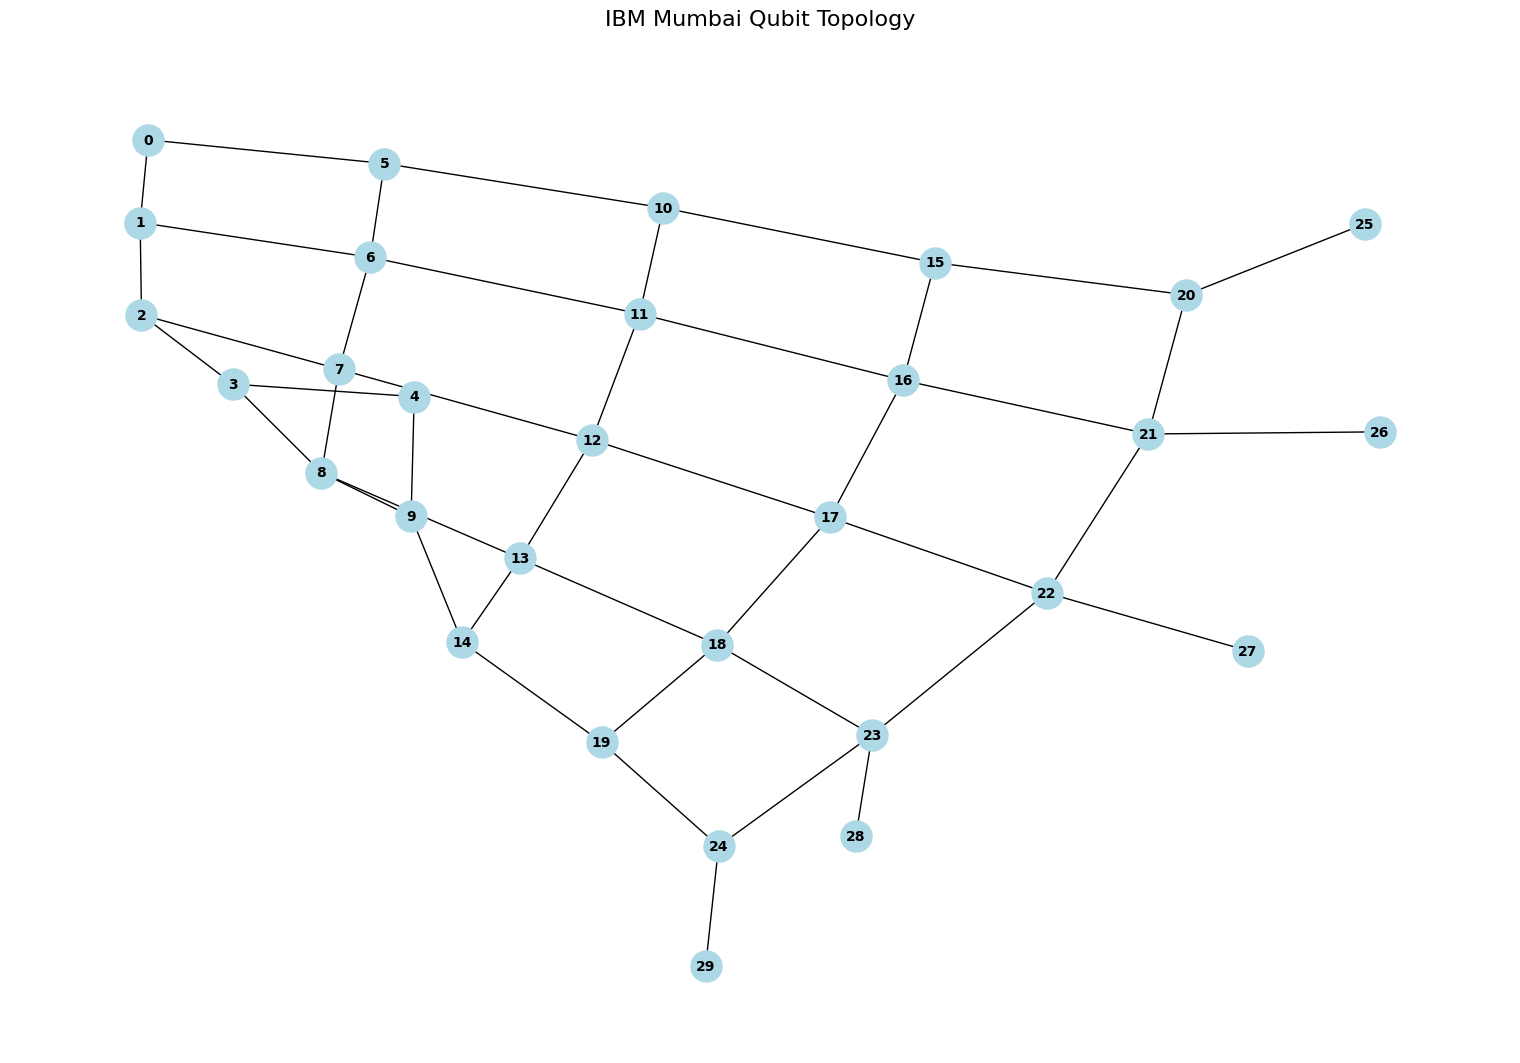

In [3]:
# Cell 3: Topology Analysis and Visualization
# Create and visualize the topology graph
coupling_map = get_ibm_mumbai_coupling()
G = nx.Graph(coupling_map)

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=500, font_size=10, font_weight='bold')
plt.title("IBM Mumbai Qubit Topology", fontsize=16, pad=20)

# Print topology statistics
print("Topology Analysis:")
print("-" * 40)
print(f"Number of qubits: {G.number_of_nodes()}")
print(f"Number of connections: {G.number_of_edges()}")
print(f"Average connectivity: {2*G.number_of_edges()/G.number_of_nodes():.2f}")
print(f"Maximum degree: {max(dict(G.degree()).values())}")
plt.show()

In [4]:
# Cell 4: Circuit Generation Analysis Function
def analyze_subcircuit_generation(topol: TopolAnsatz, n_qubits: int, depth: int):
    """Analyze the subcircuit generation process in detail"""
    print(f"\nAnalyzing {n_qubits}-qubit circuit generation with depth {depth}")
    print("=" * 50)
    
    # Generate circuit and time it
    start_time = time.time()
    circuit = topol.generate_ansatz(n_qubits=n_qubits, depth=depth)
    gen_time = time.time() - start_time
    
    # Basic properties
    print("\nCircuit Properties:")
    print("-" * 40)
    print(f"Generation time: {gen_time:.2f} seconds")
    print(f"Number of qubits: {circuit.num_qubits}")
    print(f"Circuit depth: {circuit.depth()}")
    print(f"Number of parameters: {len(circuit.parameters)}")
    
    # Gate composition analysis
    gate_counts = {}
    for inst in circuit.data:
        gate_name = inst.operation.name
        gate_counts[gate_name] = gate_counts.get(gate_name, 0) + 1

    
    # Evaluate and show metrics
    metrics = topol.evaluate_ansatz(circuit)
    print("\nCircuit Metrics:")
    print("-" * 40)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
        
    # Visualize circuit
    print("\nCircuit Diagram:")
    print(circuit.draw())
    
    return circuit, metrics

In [ ]:
# Cell 5: Test Different Circuit Sizes
topol = TopolAnsatz(coupling_map)
sizes = [4,5,6]
depths = [2, 3]

results = {}
for n_qubits in sizes:
    for depth in depths:
        print(f"\nTesting {n_qubits}-qubit circuit with depth {depth}")
        print("=" * 60)
        circuit, metrics = analyze_subcircuit_generation(topol, n_qubits, depth)
        results[(n_qubits, depth)] = metrics


Testing 4-qubit circuit with depth 2

Analyzing 4-qubit circuit generation with depth 2

Circuit Properties:
----------------------------------------
Generation time: 4.44 seconds
Number of qubits: 4
Circuit depth: 1
Number of parameters: 7

Circuit Metrics:
----------------------------------------
expressivity: 0.4878
entanglement: 0.4489
depth: 1.0000
n_parameters: 7.0000
n_cnot: 0.0000

Circuit Diagram:
     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                           ├
«     │                                                                                                            │
«q_1: ┤1                                                                                                           ├
«     │  circuit-54204(θ_sub_0_rx_6,θ_sub_0_ry_2,θ_sub_0_r

In [ ]:
# Cell 6: Topology Constraint Verification
def verify_topology_constraints(circuit: QuantumCircuit, topology: nx.Graph):
    """Verify and visualize topology constraints"""
    violations = []
    valid_gates = []
    two_qubit_gates = 0
    
    for inst in circuit.data:
        if inst.operation.name in ['cx', 'swap']:
            two_qubit_gates += 1
            q1 = inst.qubits[0]._index
            q2 = inst.qubits[1]._index
            
            if (q1, q2) in topology.edges() or (q2, q1) in topology.edges():
                valid_gates.append((q1, q2))
            else:
                violations.append((q1, q2))
    
    # Visualize topology with highlighted gates
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(topology)
    
    # Draw base topology
    nx.draw_networkx_edges(topology, pos, alpha=0.2)
    nx.draw_networkx_nodes(topology, pos, node_color='lightgray')
    nx.draw_networkx_labels(topology, pos)
    
    # Draw valid gates in green
    nx.draw_networkx_edges(topology, pos, edgelist=valid_gates, 
                          edge_color='green', width=2)
    
    # Draw violations in red
    if violations:
        G_violations = nx.Graph()
        G_violations.add_edges_from(violations)
        nx.draw_networkx_edges(G_violations, pos, edge_color='red', 
                             style='dashed', width=2)
    
    plt.title("Topology Constraint Verification")
    plt.legend(['Base topology', 'Valid gates', 'Violations'])
    plt.show()
    
    # Print statistics
    print(f"Total two-qubit gates: {two_qubit_gates}")
    print(f"Valid gates: {len(valid_gates)}")
    print(f"Violations: {len(violations)}")
    
    return len(violations) == 0

In [ ]:
# Cell 7: Compare Partitioning Strategies
def visualize_partitioning_comparison(partition_results):
    """Visualize partitioning strategy comparison"""
    strategies = list(partition_results.keys())
    metrics = list(partition_results[strategies[0]].keys())
    
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))
    
    for i, metric in enumerate(metrics):
        values = [results[metric] for results in partition_results.values()]
        axes[i].bar(strategies, values)
        axes[i].set_title(f"{metric} by Partitioning Strategy")
        axes[i].set_xticklabels(strategies, rotation=45)
    
    plt.tight_layout()
    plt.show()

# Test different partitioning strategies
partition_results = compare_partitioning_strategies(topol, 12)
visualize_partitioning_comparison(partition_results)

In [ ]:
# Cell 8: Results Summary and Visualization
def plot_results_summary(results):
    """Create summary plots for all results"""
    metrics = list(list(results.values())[0].keys())
    sizes = sorted(set(size for size, _ in results.keys()))
    depths = sorted(set(depth for _, depth in results.keys()))
    
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        for depth in depths:
            values = [results.get((size, depth), {}).get(metric, 0) 
                     for size in sizes]
            ax.plot(sizes, values, marker='o', label=f'Depth {depth}')
            
        ax.set_title(f"{metric} vs Circuit Size")
        ax.set_xlabel("Number of Qubits")
        ax.set_ylabel(metric)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Plot final results
plot_results_summary(results)

# Print summary statistics
print("\nFinal Results Summary:")
print("=" * 40)
for (size, depth), metrics in results.items():
    print(f"\n{size} qubits, depth {depth}:")
    for metric, value in metrics.items():
        print(f"- {metric}: {value:.4f}")